# Example: Graph RAG 2

Source: 
Ana Rojo-Echeburúa, **Using a Knowledge Graph to Implement a RAG Application**, https://www.datacamp.com/tutorial/knowledge-graph-rag

In [1]:
# !pip install llama-index
# !pip install llama-index-llms-openai
# !pip install llama-index-graph-stores-neo4j
# !pip install llama-index-embeddings-openai

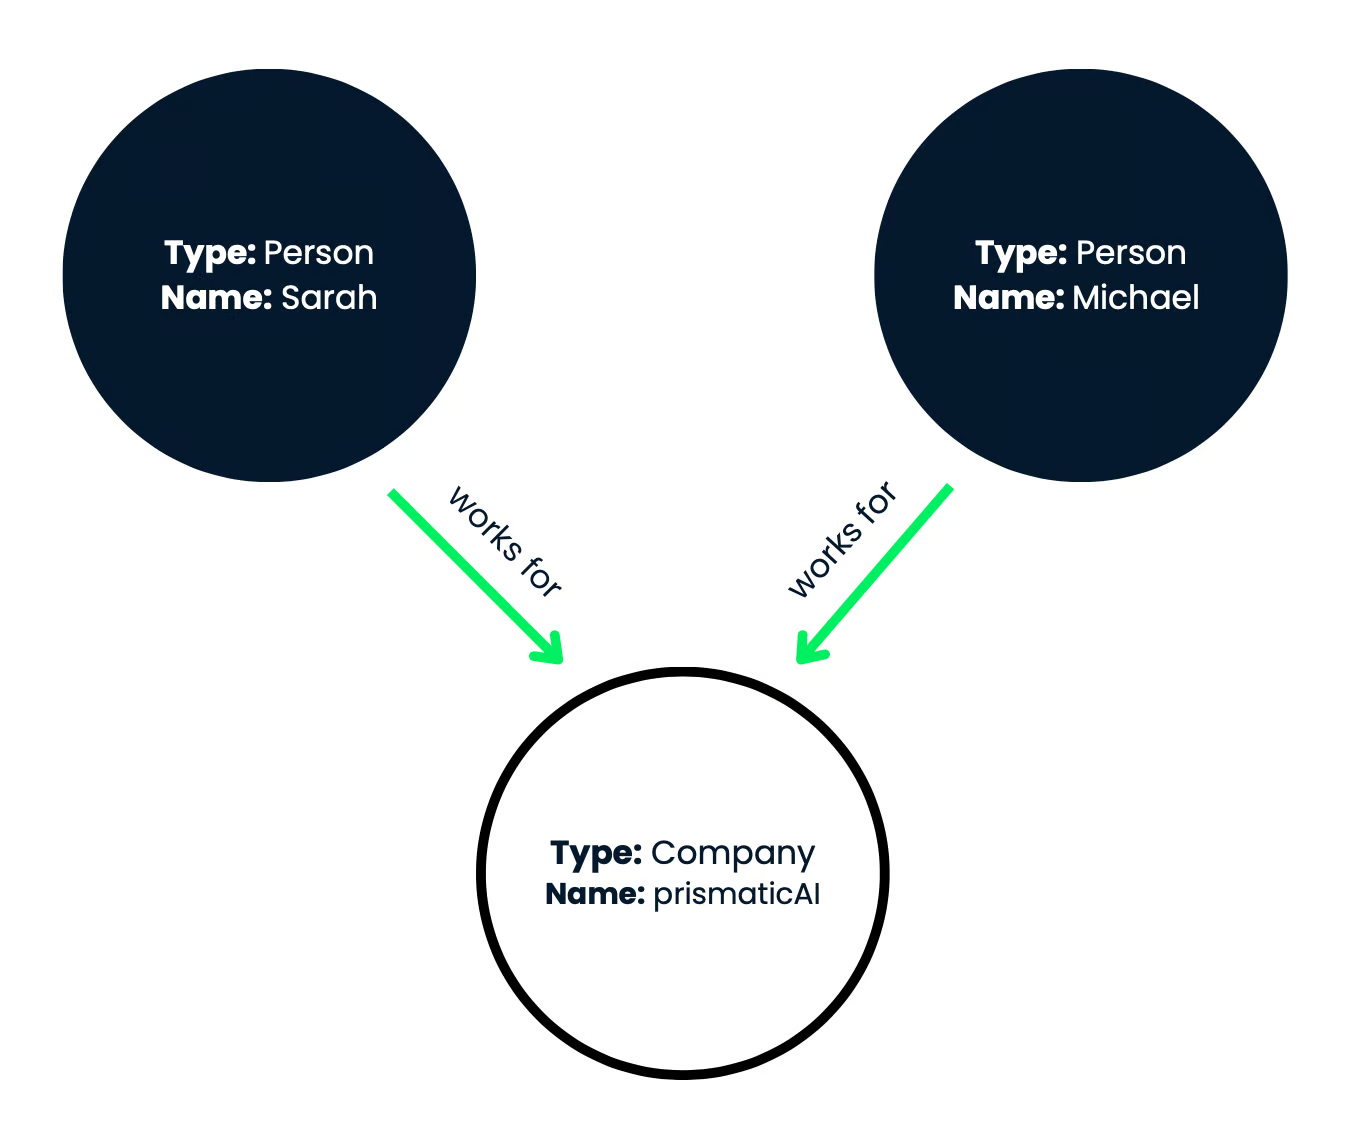

In [2]:
from IPython.display import Image
Image("figures/image1.png", width=700, height=500)

This knowledge graph effectively captures the employment relationships between the individuals Sarah and Michael and the company prismaticAI. In our example, we have three nodes:

Node 1
Type: Person
Name: Sarah
Node 2
Type: Person
Name: Michael
Node 3
Type: Company
Name: prismaticAI
In sum, we have two person nodes (Sarah and Michael) and one company node (prismaticAI). Now, let's look at the relationships (edges) between these nodes:

Relationship 1: Sarah --[works for]--> prismaticAI
This relationship indicates that Sarah, represented by Node 1, has a "works for" relationship with prismaticAI, represented by Node 3. In other words, Sarah is an employee of prismaticAI.
Relationship 2: Michael --[works for]--> prismaticAI
Similar to the first relationship, this one shows that Michael, represented by Node 2, also has a "works for" relationship with prismaticAI (Node 3). Michael is an employee of prismaticAI as well.
Querying and traversing knowledge graphs
One of the powerful aspects of knowledge graphs is the ability to query and traverse the relationships between entities to extract relevant information or infer new knowledge. Let's explore how we can do this with our example knowledge graph.

First, we need to determine what information we want to retrieve from the knowledge graph. For example:

Query 1: Where does Sarah work?

To answer the query, we need to find the appropriate starting point in the knowledge graph. In this case, we want to start from the node representing Sarah.

From the starting point (Sarah's node), we follow the outgoing "works for" relationship edge. This edge connects Sarah's node to the node representing prismaticAI. By traversing the "works for" relationship, we can conclude that Sarah works for prismaticAI.

Answer 1: Sarah works for prismaticAI.

Let's try another query:

Query 2: Who works for prismaticAI?

This time, we want to start from the node representing prismaticAI.

From the prismaticAI node, we follow the "works for" relationship edges backward. This will lead us to the nodes representing the people who work for prismaticAI. By traversing the "works for" relationships in reverse, we can identify that both Sarah and Michael work for prismaticAI.

Answer 2: Sarah and Michael work for prismaticAI.

One more example!

Query 3: Does Michael work for the same company as Sarah?

We can start from either Sarah's node or Michael's node. Let's start from Sarah's node.

We follow the "works for" relationship to reach the prismaticAI node.

Then, we check if Michael also has a "works for" relationship leading to the same prismaticAI node. Since both Sarah and Michael have a "works for" relationship with the prismaticAI node, we can conclude that they work for the same company.

Answer 3: Yes, Michael works for the same company as Sarah (prismaticAI).

Traversing the relationships in the knowledge graph allows us to extract specific pieces of information and understand the connections between entities. Knowledge graphs can become much more complex, with numerous nodes and relationships, allowing for the representation of intricate real-world knowledge in a structured and interconnected way.

### Step 1: Load and preprocess text data

In [3]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

loader = TextLoader("sarah.txt", encoding = 'UTF-8')
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=20)
texts = text_splitter.split_documents(documents)

### Step 2: Initialize language model and extract knowledge graph

In [4]:
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
import getpass
import os

openai_api_key = open("/Users/mjack6/.secrets/openai_mjack.apikey", "r").read().strip()
os.environ["OPENAI_API_KEY"] = openai_api_key

llm = ChatOpenAI(temperature=0, model_name="gpt-4-turbo")

# Extract Knowledge Graph
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(texts)

print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Sarah', type='Person', properties={}), Node(id='Prismaticai', type='Company', properties={}), Node(id='Michael', type='Person', properties={}), Node(id='Westside Valley', type='Location', properties={})]
Relationships:[Relationship(source=Node(id='Sarah', type='Person', properties={}), target=Node(id='Prismaticai', type='Company', properties={}), type='EMPLOYEE', properties={}), Relationship(source=Node(id='Michael', type='Person', properties={}), target=Node(id='Prismaticai', type='Company', properties={}), type='EMPLOYEE', properties={}), Relationship(source=Node(id='Prismaticai', type='Company', properties={}), target=Node(id='Westside Valley', type='Location', properties={}), type='BASED_IN', properties={})]


### Step 3: Store knowledge graph in a database

Install Neo4j Desktop to create a neo4j database:
https://neo4j.com/download/neo4j-desktop/?edition=desktop&flavour=osx&release=1.6.1&offline=false

Start the Neo4j Desktop application

Create a new 'Project'

Create a new 'DBMS' in your project

Install 'APOC' from your Plugin tab (see https://neo4j.com/labs/apoc/4.1/installation/)

Save your credentials:
neo4j_url = "neo4j://your_neo4j_url"
neo4j_username = "your_username"
neo4j_password = "your_password"

In [5]:
# See LangChain and LllamIndex documentation:
# LangChain - How to construct knowledge graphs
# https://python.langchain.com/v0.2/docs/how_to/graph_constructing/
#
# LlamaIndex - Response Synthesizer
# https://docs.llamaindex.ai/en/stable/module_guides/querying/response_synthesizers/

from llama_index.graph_stores.neo4j import Neo4jGraphStore

neo4j_url = "bolt://localhost:7687"
neo4j_username = "neo4j"
neo4j_password = open("/Users/mjack6/.secrets/neo4j.secret", "r").read().strip()
neo4j_database = "neo4j"

# Store Knowledge Graph in Neo4j
graph_store = Neo4jGraphStore(
    url=neo4j_url, 
    username=neo4j_username, 
    password=neo4j_password,
    database=neo4j_database,
    )

In [6]:
from llama_index.core import StorageContext, KnowledgeGraphIndex, SimpleDirectoryReader

storage_context = StorageContext.from_defaults(graph_store=graph_store)

documents = SimpleDirectoryReader("./").load_data()

index = KnowledgeGraphIndex.from_documents(
    documents=documents,
    storage_context=storage_context,
    max_triplets_per_chunk=2,
)

/var/folders/tj/cfj9qmvs7150dnbbhjnzz1tw0000gq/T/ipykernel_83813/819960579.py:7: DeprecationWarning: Call to deprecated class KnowledgeGraphIndex. (The KnowledgeGraphIndex class has been deprecated. Please use the new PropertyGraphIndex class instead. If a certain graph store integration is missing in the new class, please open an issue on the GitHub repository or contribute it!) -- Deprecated since version 0.10.53.
  index = KnowledgeGraphIndex.from_documents(


### Step 4: Retrieve knowledge for RAG

In [7]:
# Retrieve Knowledge for RAG
from llama_index.core.retrievers import KnowledgeGraphRAGRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

graph_rag_retriever = KnowledgeGraphRAGRetriever(
    storage_context=storage_context, 
    verbose=True
    )
query_engine = RetrieverQueryEngine.from_args(graph_rag_retriever)

### Step 5: Query the knowledge graph and generate a response

In [8]:
def query_and_synthesize(query):
    query_engine = RetrieverQueryEngine.from_args(
        graph_rag_retriever,
    )
    response = query_engine.query(query)
    print(f"Query: {query}")
    print(f"Answer: {response}\n")

# Query 1
query_and_synthesize("Where does Sarah work?")

# Query 2
query_and_synthesize("Who works for prismaticAI?")

# Query 3
query_and_synthesize("Does Michael work for the same company as Sarah?")

Query: Where does Sarah work?
Answer: Sarah works at Prismaticai in Westside valley.

Query: Who works for prismaticAI?
Answer: Developing software solutions.

Query: Does Michael work for the same company as Sarah?
Answer: Yes.

